## DBSCAN algorithm

DBSCAN is an algorithm used frequently with low dimension data, when shapes are complex.
<br>
Typical examples are identifcation of high density areas on geographic maps (location of traffic accidents or natural events), clustering of locations in GPS data, image processing (grouping similar pixels) or computer vision.

By default it uses the Euclidean distance, although this one does not work well on high dimensionality, due to the curse of dimensionality.

Alternatives in these situations are:
- choose a different distance measuare (for instance, Manhattan, cosine or correlation)
- choose the version of DBSCAN more prepared to work with high dimensions, called HDBSCAN (hierarchical one), or other algorithm 
- consider running a Dimension Reduction

In high dimensionality, epsilon hyperparameter is more difficult to adjust, since it tends to consider lots of data as noise or in a unique cluste

#### First thing is to define the data set: a face with two eyes and a smile

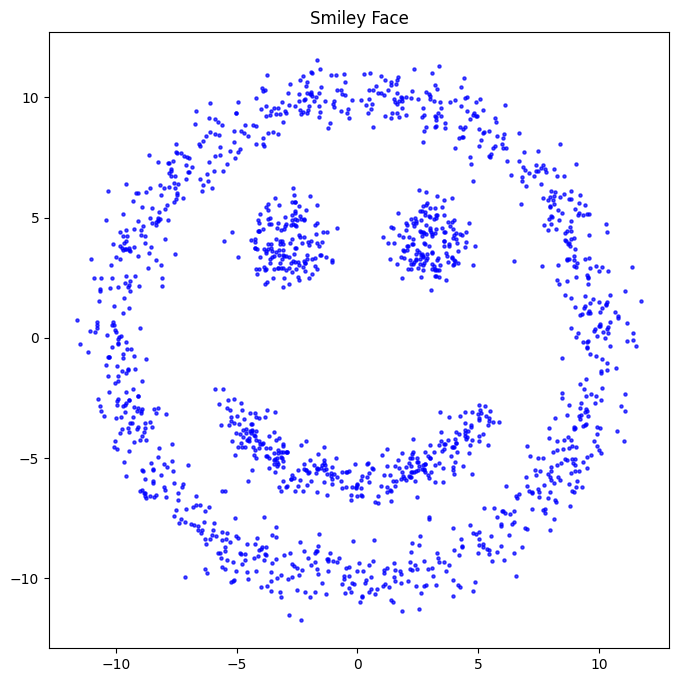

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generates the eyes (circles)
def generate_circle_cloud(center, radius, num_points=300, noise=0.3):
    angles = np.random.uniform(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.cos(angles) + np.random.normal(0, noise, num_points)
    y = center[1] + radius * np.sin(angles) + np.random.normal(0, noise, num_points)
    return np.column_stack((x, y))

# Generates the mouth (arc)
def generate_arc_cloud(center, radius, theta_start, theta_end, num_points=300, noise=0.5):
    angles = np.random.uniform(theta_start, theta_end, num_points)
    x = center[0] + radius * np.cos(angles) + np.random.normal(0, noise, num_points)
    y = center[1] + radius * np.sin(angles) + np.random.normal(0, noise, num_points)
    return np.column_stack((x, y))

# Parameters
face_center = (0, 0)
face_radius = 10
eye_radius = 1
eye_distance = 3
mouth_radius = 6

# Cloud of dots: noise can be increase to produce less dense group of dots 
face = generate_circle_cloud(face_center, face_radius, num_points=1000, noise=0.7)  # Face
left_eye = generate_circle_cloud((-eye_distance, 4), eye_radius, num_points=150, noise=0.5)  # Left eye
right_eye = generate_circle_cloud((eye_distance, 4), eye_radius, num_points=150, noise=0.5)  # Right eye
mouth = generate_arc_cloud((0, 0), mouth_radius, theta_start=-5 * np.pi / 6, theta_end=-np.pi / 6) # Mouth

# Combine all and visualite
data = np.vstack((face, left_eye, right_eye, mouth))
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=5, color='blue', alpha=0.7)
plt.title("Smiley Face")
plt.axis('equal')
plt.show()

#### Create the dataframe

In [2]:
import pandas as pd
df_smiley = pd.DataFrame(data, columns=['X', 'Y'])
df_smiley

,X,Y
0,-6.411613,-7.975757
1,4.313693,-8.714613
2,-7.411872,-6.720124
3,-0.280031,-10.550979
4,9.926074,-4.502609
...,...,...
1595,-3.451767,-4.769119
1596,1.214967,-4.629374
1597,4.446457,-3.814595
1598,2.751586,-5.434582


#### Run the algorithm and draw the clusters found

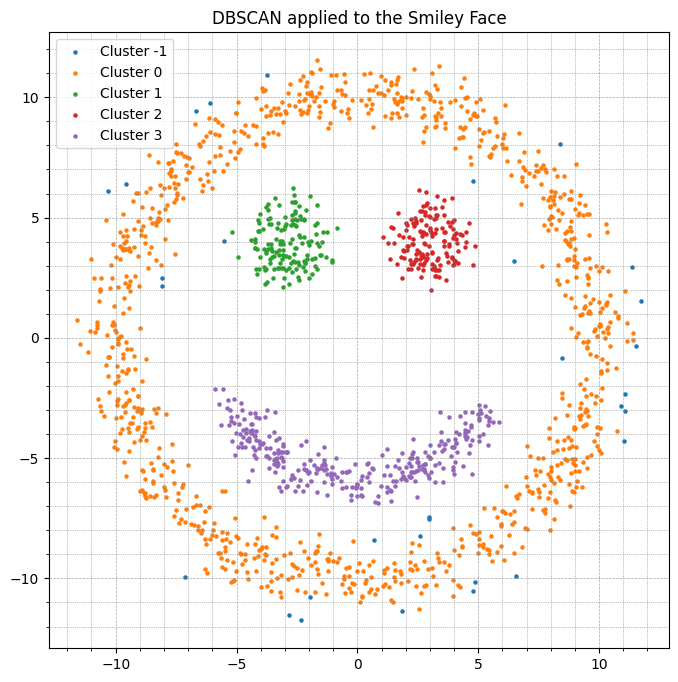

In [3]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# hyperparameters definition: play with thse numbers to understand their behaviour
eps = 1
min_samples = 15

dbscan = DBSCAN(eps=eps, min_samples=min_samples)  

df_smiley['Cluster'] = dbscan.fit_predict(df_smiley[['X', 'Y']])

plt.figure(figsize=(8, 8))

# Graficar cada clúster con un color diferente
for cluster in sorted(df_smiley['Cluster'].unique()):
    cluster_points = df_smiley[df_smiley['Cluster'] == cluster]
    plt.scatter(
        cluster_points['X'], cluster_points['Y'],
        s=5,
        label=f'Cluster {cluster}'
    )

# Configurar el gráfico
plt.title("DBSCAN applied to the Smiley Face")
plt.axis('equal')
plt.minorticks_on()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.legend()
plt.show()

There are three types of points:

- **Core points**: They have at least a minimum number of neighbors within the radius ϵ
- **Boundary points**: They don´t have at least a minimum number of neighbors within the radius ϵ, but they are within it from a core point
- **Noise (outliers)**: They are far away from all core points or clusters to be considered part of them

Reasons why a point is considered an **outlier**:

- **Low local density**: The point does not have enough neighbors within the radius ϵ to comply with minPts.
For example, if minPts=5, but a point has only 2 neighbors within ϵ, it will be classified as noise.
- **Cluster remoteness**: The point is too far away from any existing cluster, so it cannot be classified as a boundary point.
- **Inappropriate choice of ϵ**: A value too small can cause many points to be isolated and considered noise. A value too large may include too many points in a cluster, reducing algorithm's ability to distinguish outliers.
- **Intrinsic data structure**: Some data naturally have isolated points that do not fit into any dense cluster. This is common in data sets with background noise.
